In [1]:
import torch.nn as nn

num_channels = 3
hidden_size = 768
patch_size = 16
conv = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

In [110]:
import torch

fake_image = torch.rand((1, 3, 224, 168))

print(conv(fake_image).reshape(1, -1, 768).shape)

torch.Size([1, 140, 768])


In [111]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

In [28]:
import numpy as np
import math
import cv2
import torch
from transformers import ViTConfig


def resize_with_aspect_ratio(
        pixel_values: np.ndarray, effective_resolution: int
):
    """

    :param pixel_values: of shape (batch_size, num_channels, x_size, y_size)
    :return:
    """

    # TODO: might have to be moved to the preprocessor
    _, _, x_size, y_size = pixel_values.shape

    aspect_ratio = x_size / y_size

    new_y = np.sqrt(effective_resolution ** 2 / aspect_ratio)
    new_x = new_y * aspect_ratio

    rounded_y = math.floor(new_y)
    rounded_x = math.floor(new_x)
    res = cv2.resize(
        torch.permute(pixel_values.squeeze(0), (1,2,0)).numpy(),
        dsize=(rounded_y, rounded_x),
        interpolation=cv2.INTER_CUBIC,
    )
    img = (
        torch.tensor(res, dtype=torch.float)
        .view(3, rounded_x, rounded_y)
        .unsqueeze(0)
    )
    return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


64
128
224
512
768


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1024


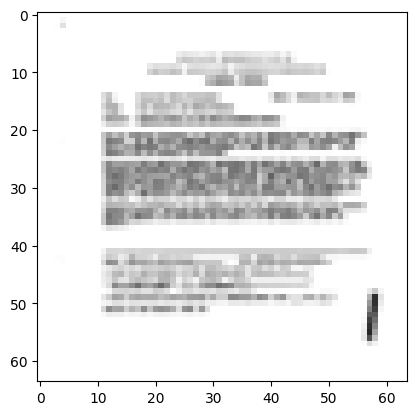

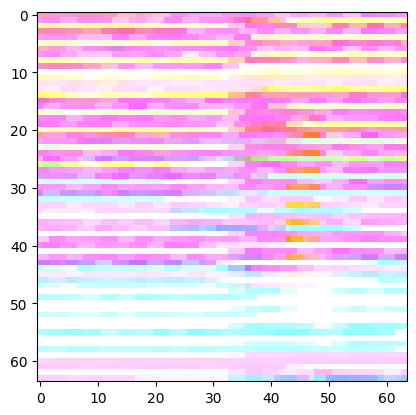

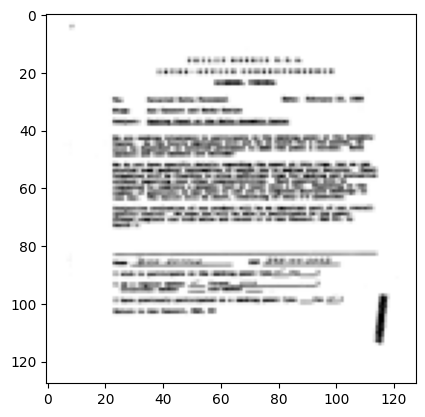

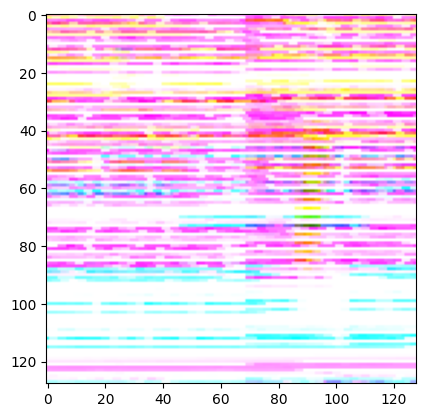

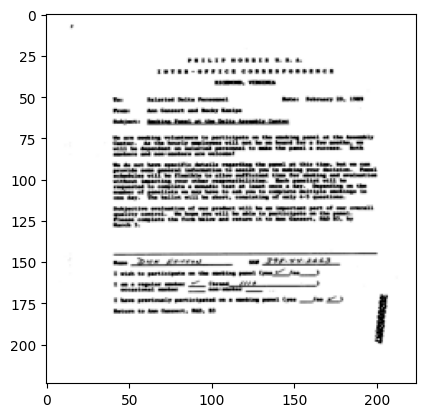

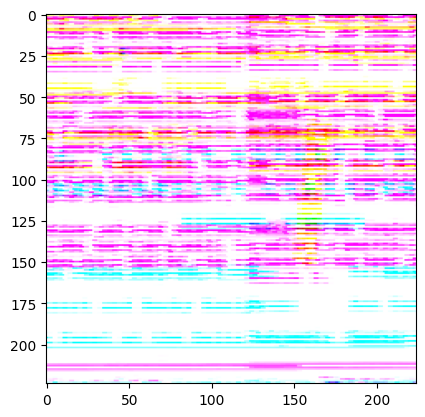

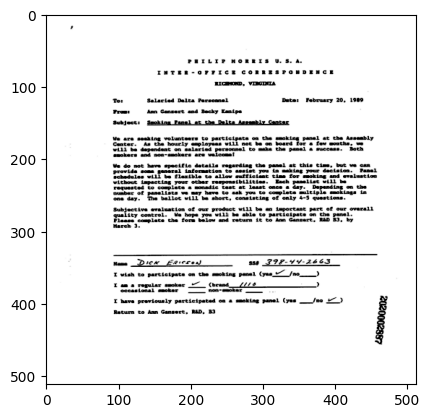

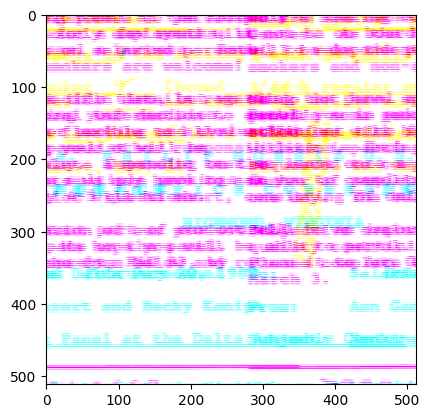

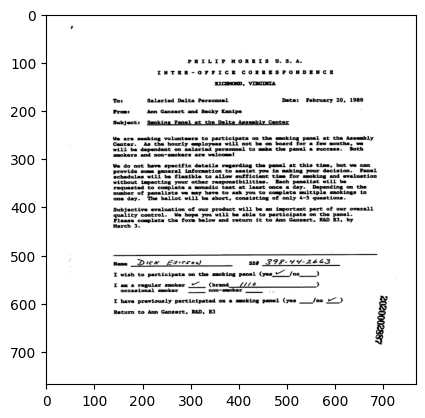

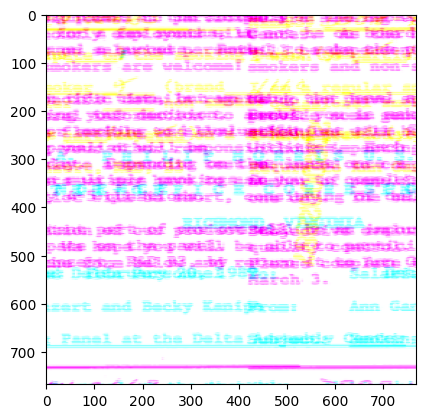

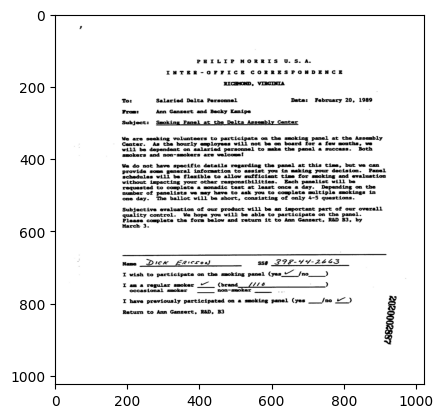

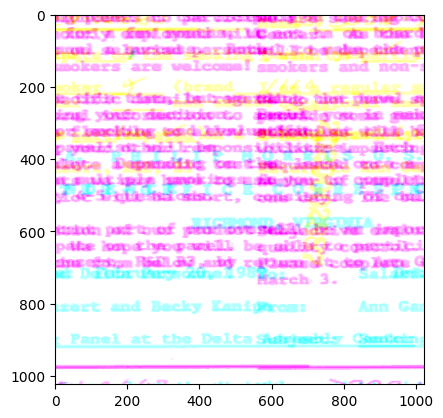

In [42]:
from datasets import load_dataset
from transformers import ViTConfig, ViTImageProcessor 
import matplotlib.pyplot as plt
import torch

resolutions = [64, 128, 224, 512, 768, 1024]
val_dataset = load_dataset("aharley/rvl_cdip", split='validation')
img = next(iter(val_dataset))['image']

for resolution in resolutions:
    print(resolution)
    config = ViTConfig(num_labels=10, image_size=resolution)
    processor = ViTImageProcessor(config, size={"height": config.image_size, "width": config.image_size})
    processed_img = processor(img.convert('RGB'))
    plt.figure()
    plt.imshow(processed_img.pixel_values[0].transpose(1,2,0))
    plt.figure()
    plt.imshow(resize_with_aspect_ratio(torch.tensor(processed_img.pixel_values[0]).unsqueeze(0), resolution).squeeze(0).numpy().transpose(1,2,0))

In [41]:
resize_with_aspect_ratio(torch.tensor(processed_img.pixel_values[0]).unsqueeze(0), resolution).squeeze(0).numpy().transpose(1,2,0).shape

(64, 64, 3)

In [158]:
# How to compute the positional embeddings

# BS, hidden dim, x patches, y patches
patches = conv(fake_image)
# print(patches.shape)

# To project to the right hidden embedding dim
hidden_dim = 768
x_projection = torch.nn.Linear(1, hidden_dim)
y_projection = torch.nn.Linear(1, hidden_dim)

batch_size, x_size, y_size = patches.shape[0], patches.shape[2], patches.shape[3]

# x_embeddings
patches_x_embeddings = torch.arange(x_size).view(batch_size, 1, -1) / x_size
patches_x_embeddings = x_projection(patches_x_embeddings.T).view(batch_size, x_size, hidden_dim)
patches_x_embeddings = patches_x_embeddings.expand(y_size, batch_size, x_size, hidden_dim)
patches_x_embeddings = patches_x_embeddings.reshape(batch_size, -1, hidden_dim)

# y_embeddings
patches_y_embeddings = torch.arange(y_size).view(batch_size, 1, -1) / y_size
patches_y_embeddings = y_projection(patches_y_embeddings.T).view(batch_size, y_size, hidden_dim)
patches_y_embeddings = patches_y_embeddings.expand(x_size, batch_size, y_size, hidden_dim)
patches_y_embeddings = patches_y_embeddings.reshape(batch_size, -1, hidden_dim)

patches_positional_embeddings = patches_x_embeddings + patches_y_embeddings

In [165]:
# Retaining the aspect ratio for a given effective resolution

img1 = torch.rand((1, 3, 1024, 512))
img2 = torch.rand((1, 3, 256, 272))

patches_1 = conv(img1)
patches_2 = conv(img2)
print(f'num_patches={patches_1.shape[-1]*patches_1.shape[-2]}')
print(f'num_patches={patches_2.shape[-1]*patches_2.shape[-2]}')

num_patches=2048
num_patches=272


In [35]:
1024 / 16

64.0

In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(pixel_values=inputs.pixel_values)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

/Users/arnaudstiegler/forms/ml_framework/venv/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: Required library version not found: libsbitsandbytes_cpu.so. Maybe you need to compile it from source?
CUDA SETUP: Defaulting to libbitsandbytes_cpu.so...
dlopen(/Users/arnaudstiegler/forms/ml_framework/venv/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so, 6): no suitable image found.  Did find:
	/Users/arnaudstiegler/forms/ml_framework/venv/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: unknown file type, first eight bytes: 0x7F 0x45 0x4C 0x46 0x02 0x01 0x01 0x00
	/Users/arnaudstiegler/forms/ml_framework/venv/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: unknown file type, first eight bytes: 0x7F 0x45 0x4C 0x46 0x02 0x01 0x01 0x00


/Users/arnaudstiegler/forms/ml_framework/venv/lib/python3.9/site-packages/bitsandbytes/cextension.py:31: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


Predicted class: Egyptian cat


In [4]:
inputs.pixel_values.shape

torch.Size([1, 3, 224, 224])

In [45]:
# Retaining the aspect ratio for a given effective resolution
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import math
import cv2 

num_channels = 3
hidden_size = 768
patch_size = 16
conv = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

effective_resolution = 512

for x_size, y_size in [(1024, 512), (1024, 1024), (256, 256), (1121, 456)]:
    imarray = torch.rand(x_size, y_size,3) * 255
    # im = Image.fromarray(imarray.astype('uint8'))

    aspect_ratio = x_size / y_size

    new_y = np.sqrt(effective_resolution**2/aspect_ratio)
    new_x = new_y * aspect_ratio
    
    
    rounded_y = math.floor(new_y)
    rounded_x = math.floor(new_x)
    # resized_img = im.resize(())
    res = cv2.resize(imarray, dsize=(rounded_y, rounded_x), interpolation=cv2.INTER_CUBIC)
    print(rounded_y, rounded_x)
    print(rounded_x / rounded_y, aspect_ratio)
    print(effective_resolution**2, rounded_x*rounded_y)
    img = torch.tensor(res, dtype=torch.float).view(3, rounded_x, rounded_y).unsqueeze(0)

    patches = conv(img)
    print(f'num_patches={patches.shape[-1]*patches.shape[-2]}')
    
    # Then we need to pad to the max

error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [31]:
patches = patches.view(1, hidden_size, -1)
seq_length = patches.shape[-1]
max_patches = int((effective_resolution**2)/(patch_size**2))
torch.nn.functional.pad(patches, (0,max_patches-seq_length)).shape

torch.Size([1, 768, 1024])

In [1]:
from transformers.models.vit.image_processing_vit import ViTImageProcessor

/Users/arnaudstiegler/forms/ml_framework/venv/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
from transformers.models.vit.feature_extraction_vit import ViTFeatureExtractor

In [9]:
from extractor import PatchPackProcessor
from model import PatchPackModel, PatchPackModelImageClassification
from PIL import Image
import requests

processor = PatchPackProcessor.from_pretrained("google/vit-base-patch16-224")

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
processor(image, return_tensors="pt")['pixel_values'].shape

torch.Size([1, 3, 480, 640])

In [19]:
from transformers import ViTConfig

config = ViTConfig()
model = PatchPackModelImageClassification(config)

In [11]:
# Load model directly
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

In [8]:
type(model)

transformers.models.vit.modeling_vit.ViTForImageClassification

In [51]:
1024*512

524288

In [6]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig
from PIL import Image
import requests
import torch


MAX_EPOCHS = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

In [8]:
config = ViTConfig()
processor = ViTImageProcessor(config)
model = ViTForImageClassification(config)

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("aharley/rvl_cdip", split='train')
test_dataset = load_dataset("aharley/rvl_cdip", split='test')

/home/arnaud/learning_resources/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_dataset.save_to_disk("/home/arnaud/rvl_cdip_dataset/rvl_cdip_train.arrow")

Saving the dataset (7/10 shards):  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 31000/40000 [00:11<00:03, 2694.38 examples/s]


OSError: [Errno 28] No space left on device